<a href="https://colab.research.google.com/github/gcbirat12/All_Projects/blob/main/CNN_Histopathologic_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'histopathologic-cancer-detection:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F11848%2F862157%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240625%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240625T201924Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3b5c4ce66953b64bdcdd90c5365d04a46eaf3544dbd3e2905e8fad93a9caf18319a60121535ac3882b1fe87ef406f4eb5e6e458da3e42d34b429cf241f2528a7c85e010a971b444b4810a0b07345dfa9125897b72083e09cc15c7ccc392dec79298c8e9c5e0e05b48e5db0747712bc31ccd6d578c52e1a5b7fc9c11ab9d7ffeb7db67afe21380758cc258f06a966c157304b12dd2e2d125f79697d7b47333b630fa12442606ad9a1c3d10325ba639d2d943fd211e17832a72922ce272af9169fe2e23163ad197c4463db31e8b4c995d9b27f593913586bba7b89ab6377c0ba28db62af32d87fd6679c91aecbd83bf9ad0581434069a53c32ddab874b81ac9733'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 6773228425 bytes downloaded
Downloaded and uncompressed: histopathologic-cancer-detection
Data source import complete.


# Project Overview: Identifying Metastatic Cancer Using CNNs

## Introduction

This project aims to develop a convolutional neural network (CNN) to identify metastatic cancer in digital pathology scans. Metastatic cancer, or metastatic tumors, are cancers that have spread from the primary site to other parts of the body. Early and accurate detection is crucial for effective treatment and patient prognosis.

Using deep learning techniques, particularly CNNs, we can leverage the power of image processing to assist in the diagnosis of metastatic cancer. The CNN model will be trained on a dataset of labeled digital pathology images, learning to distinguish between images with and without tumor tissue.

## Project Goals

- Develop a CNN model to classify digital pathology images as either containing metastatic tumor tissue or not.
- Utilize a training dataset to teach the model the distinguishing features of metastatic cancer.
- Implement techniques to prevent overfitting, such as early stopping.
- Evaluate the model's performance using appropriate metrics, including accuracy and recall.
- Create a reproducible workflow that can be used for further research and development in medical image analysis.

## Dataset

The dataset consists of digital pathology images categorized into two classes: images with metastatic tumor tissue and images without. The images are stored in directories named `train` and `test`, with further subdirectories for each class. The `train` directory contains images for model training, while the `test` directory is used for evaluating the model's performance.



In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/histopathologic-cancer-detection/train/b0da87f89f0f319c9b1a4d0b06aa5e20b7d9d086.tif
/kaggle/input/histopathologic-cancer-detection/train/7eb98ca35e92d993bb77d4fbef36a85a5f12c317.tif
/kaggle/input/histopathologic-cancer-detection/train/5f0b67b524a2b326ace5122215c9dc909dce1ce5.tif
/kaggle/input/histopathologic-cancer-detection/train/709b3a212b6e7ac325b532a17dfe72274ac4888b.tif
/kaggle/input/histopathologic-cancer-detection/train/b089787356bee01d826191dbd6c53edea835ed8e.tif
/kaggle/input/histopathologic-cancer-detection/train/d69c8d39553d778bf4901405762f61b63ab4693f.tif
/kaggle/input/histopathologic-cancer-detection/train/9e8a78b0e3c3b17381642cde5a1aaa3eb8b57442.tif
/kaggle/input/histopathologic-cancer-detection/train/c643a60663b00c2ea53641b182fafa3a17475c12.tif
/kaggle/input/histopathologic-cancer-detection/train/711a5db492eaaef897b358456a0620589f11191b.tif
/kaggle/input/histopathologic-cancer-detection/train/b81276029cce5f

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
/kaggle/input/histopathologic-cancer-detection/train/060ecb84a579fcc98c0d427d25c6732ccbe21d40.tif
/kaggle/input/histopathologic-cancer-detection/train/05ec06dadaaf3556cf868a02cedd27f98121d966.tif
/kaggle/input/histopathologic-cancer-detection/train/52ce7e3abd3748822b89349df5117ac6982faa9e.tif
/kaggle/input/histopathologic-cancer-detection/train/3284213e77165b6abcc1a14cc8952f114c3f9f69.tif
/kaggle/input/histopathologic-cancer-detection/train/4da228ebee9691e24808c2712041ec8111f0dd01.tif
/kaggle/input/histopathologic-cancer-detection/train/376f58f28245c6d038ff27c226915b4939ac2f29.tif
/kaggle/input/histopathologic-cancer-detection/train/a4424b954066d680f14092aecfa3d3d9ae036ac5.tif
/kaggle/input/histopathologic-cancer-detection/train/a9cfcc53eada2352a7b09c78893cdb6728a6ed8d.tif
/kaggle/input/histopathologic-cancer-detection/train/378ec52fc4b410f1893c877c70a06aa8ab29a4ab.tif
/kaggle/input/histopathologic-cancer-detection/train/2821473272055e

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
/kaggle/input/histopathologic-cancer-detection/train/47949daafe67a31ec87010ed99d94a7cd78ebbd3.tif
/kaggle/input/histopathologic-cancer-detection/train/03b130508c90078a7861caebae87929acb3ae17d.tif
/kaggle/input/histopathologic-cancer-detection/train/ff8b432dee6af5e9ec6ef4b92e4441c9560818c1.tif
/kaggle/input/histopathologic-cancer-detection/train/649303a3e7ae872e44c35f3be8d87021ea9c95fb.tif
/kaggle/input/histopathologic-cancer-detection/train/3a2ba5e29539a766d2a7bb0546780c99bdb965ca.tif
/kaggle/input/histopathologic-cancer-detection/train/b0855b8748b2f33475889f9d9766b23f31834367.tif
/kaggle/input/histopathologic-cancer-detection/train/ef52e110c3b5e2a8cc25a95fa6e3c36167060040.tif
/kaggle/input/histopathologic-cancer-detection/train/d9abf90718919e7679f7762b5067b491a71e593d.tif
/kaggle/input/histopathologic-cancer-detection/train/7595c14401ff701ba97b635c1f0ca6e805388fde.tif
/kaggle/input/histopathologic-cancer-detection/train/a9cfdc1ef2fcb7

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
/kaggle/input/histopathologic-cancer-detection/test/94fdd2922894409b60521d7f545b150d46662a1d.tif
/kaggle/input/histopathologic-cancer-detection/test/f4378b9e675e0439a63a49a857113734d3d26f9c.tif
/kaggle/input/histopathologic-cancer-detection/test/6dca13a8e30db9aca74362c48747148b8a0eb9dc.tif
/kaggle/input/histopathologic-cancer-detection/test/82973f696a8b326c019b37bf4235205b236beb75.tif
/kaggle/input/histopathologic-cancer-detection/test/3ca69c75f54face2219167daffc639066bafd1d4.tif
/kaggle/input/histopathologic-cancer-detection/test/9ccaeb5ae7ca151eb7306883336a3ae838819ad3.tif
/kaggle/input/histopathologic-cancer-detection/test/b155c3623215cf48479844fd900ba13215428978.tif
/kaggle/input/histopathologic-cancer-detection/test/add670d431e879720355215a49ed8f7752de5541.tif
/kaggle/input/histopathologic-cancer-detection/test/ac5d432c4255f2a75515aed5a02c039b9e6da38a.tif
/kaggle/input/histopathologic-cancer-detection/test/8cf8d9edb23e62fed76846ec

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



/kaggle/input/histopathologic-cancer-detection/test/409da1324134ab2c0b3d50fdd13e2d1fd87a1896.tif
/kaggle/input/histopathologic-cancer-detection/test/03b340b9d81ec7572598d2c0bef7e304dd928859.tif
/kaggle/input/histopathologic-cancer-detection/test/81a96e0d80a22b1f6f30439637e944c5eefe3edc.tif
/kaggle/input/histopathologic-cancer-detection/test/4b5dc84cc60ebafe5c8c449070ac59a9e0ed639f.tif
/kaggle/input/histopathologic-cancer-detection/test/e73775a56a917ef78cce28a283c5e5f630f5d6b0.tif
/kaggle/input/histopathologic-cancer-detection/test/1252241f541bed635a01cc5517a3aac1847d2e83.tif
/kaggle/input/histopathologic-cancer-detection/test/305054862cb527ad25e443da6bda77897877a9b5.tif
/kaggle/input/histopathologic-cancer-detection/test/89ba4004ca25a5c272982c5899e5ae4ea66e05bd.tif
/kaggle/input/histopathologic-cancer-detection/test/00dc10f383fc2736de2f3b196e55c063b1d52ff2.tif
/kaggle/input/histopathologic-cancer-detection/test/315c0861b673752be7f4e79960ed289f27cf561c.tif
/kaggle/input/histopathologic-

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.metrics import Recall

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

##EDA

In [ ]:
# Define directories for training and testing data
train_directory = '/kaggle/input/histopathologic-cancer-detection/train'
test_directory= '/kaggle/input/histopathologic-cancer-detection/test'
submission_sample = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/sample_submission.csv')
training_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

In [ ]:
# Display dataset information
print(training_labels.info())
print(training_labels.head())
print(submission_sample.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB
None
                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57458 entries, 0 to 57457
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      57458 non-null  object
 1   label   57458 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 897.9+ KB
None


In [ ]:
def display_images(image_ids, labels, directory, title):
    plt.figure(figsize=(15, 5))
    for i, (img_id, label) in enumerate(zip(image_ids, labels)):
        img_path = os.path.join(directory, img_id + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, len(image_ids), i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


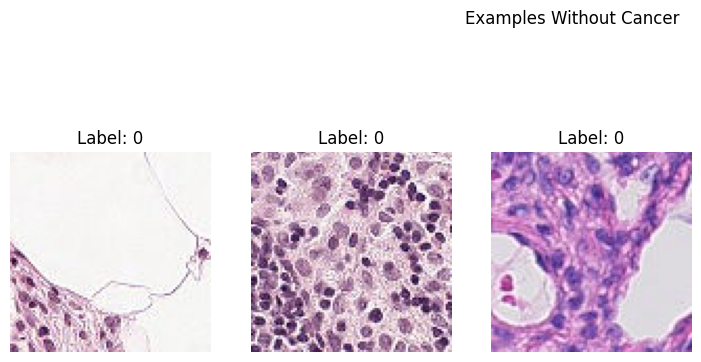

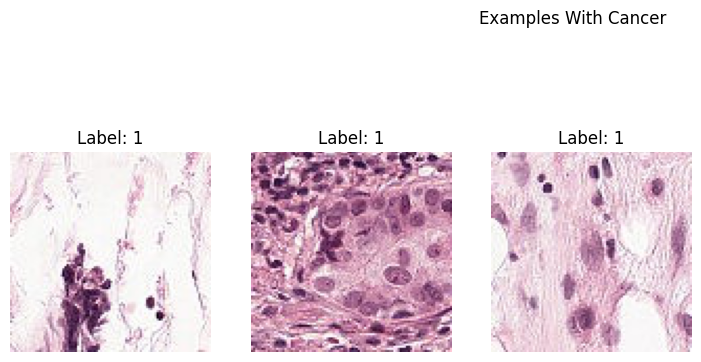

Total number of training images: 220025
Total number of testing images: 57458
Total number of images in the dataset: 277483


In [ ]:
display_images(training_labels[training_labels['label'] == 0]['id'][:5], [0]*3, train_directory, "Examples Without Cancer")
display_images(training_labels[training_labels['label'] == 1]['id'][:5], [1]*3, train_directory, "Examples With Cancer")

num_train_imgs = len(os.listdir(train_directory))
num_test_imgs = len(os.listdir(test_directory))
total_images = num_train_imgs + num_test_imgs
print(f"Total number of training images: {num_train_imgs}")
print(f"Total number of testing images: {num_test_imgs}")
print(f"Total number of images in the dataset: {total_images}")


## Data Preprocessing

To prepare the data for training and validation, the following steps are taken:

1. **Image Resizing and Batch Size Configuration**
2. **Data Augmentation and Rescaling**
3. **Label Preparation:**
4. **Data Generators for Training and Validation**

In [ ]:
img_size = (60, 60)  # Resizing
batch_sz = 256

data_generator = ImageDataGenerator(rescale=1./255,  validation_split=0.25
                                   )

training_labels['label'] = training_labels['label'].astype(str)

training_labels['id'] = training_labels['id'].apply(lambda x: x + '.tif')

train_gen = data_generator.flow_from_dataframe(dataframe=training_labels, directory=train_directory,x_col='id',y_col='label',target_size=img_size,batch_size=batch_sz,class_mode='binary',workers=4,use_multiprocessing=True, subset='training', shuffle=True)

val_gen = data_generator.flow_from_dataframe(dataframe=training_labels, directory=train_directory,x_col='id', y_col='label',target_size=img_size,batch_size=batch_sz,class_mode='binary',workers=4,use_multiprocessing=True,subset='validation',shuffle=True)


Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


## Model Definition and Training

1. **Model Architecture:**
    - **Convolutional Layer:** 16 filters, 3x3 kernel, ReLU activation, input shape (60, 60, 3).
    - **Pooling Layer:** MaxPooling2D with a 2x2 pool size.
    - **Flatten Layer:** Converts 2D output to 1D.
    - **Output Layer:** Dense layer with 1 neuron, sigmoid activation.

2. **Model Compilation:**
    - Optimizer: Adam.
    - Loss Function: Binary cross-entropy.
    - Metrics: Accuracy and recall.

3. **Training Configuration:**
    - Steps per epoch defined for training and validation.
    - Early stopping callback to prevent overfitting (monitors validation loss, patience of 3 epochs).

4. **Model Training:**
    - Training for 3 epochs with early stopping.
    - Validation data used to monitor performance and adjust weights.


In [ ]:
cnn_model_single_layer = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(1, activation='sigmoid')
])

cnn_model_single_layer.compile(optimizer='adam',
                               loss='binary_crossentropy',
                               metrics=['accuracy', Recall(name='recall')])

cnn_model_single_layer.summary()

train_steps = train_gen.samples // train_gen.batch_size
val_steps = val_gen.samples // val_gen.batch_size

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = cnn_model_single_layer.fit(train_gen,
                                     steps_per_epoch=train_steps,
                                     epochs=3,
                                     validation_data=val_gen,
                                     validation_steps=val_steps,
                                     callbacks=[early_stop])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 58, 58, 16)        448       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 29, 29, 16)        0         
 g2D)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 13456)             0         
                                                                 
 dense_8 (Dense)             (None, 1)                 13457     
                                                                 
Total params: 13905 (54.32 KB)
Trainable params: 13905 (54.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/3
644/644 [==============================] - 639s 988ms/step - loss: 0.4879 

## Conclusion and Discussion

### Model Performance

The CNN model was trained for 3 epochs, and the performance metrics, including loss, accuracy, and recall, were monitored. The model's architecture comprised a convolutional layer, a max-pooling layer, a flatten layer, and a dense output layer.

**Model Summary:**
- **Convolutional Layer:** 16 filters, 3x3 kernel, ReLU activation.
- **MaxPooling Layer:** 2x2 pool size.
- **Flatten Layer:** Converts the 2D output to 1D.
- **Dense Layer:** Single neuron, sigmoid activation.

**Training Results:**
- **Epoch 1:**
  - Training Loss: 0.4879
  - Training Accuracy: 0.7700
  - Training Recall: 0.6709
  - Validation Loss: 0.4431
  - Validation Accuracy: 0.8001
  - Validation Recall: 0.7725
- **Epoch 2:**
  - Training Loss: 0.4366
  - Training Accuracy: 0.8025
  - Training Recall: 0.7338
  - Validation Loss: 0.4271
  - Validation Accuracy: 0.8116
  - Validation Recall: 0.6910
- **Epoch 3:**
  - Training Loss: 0.4204
  - Training Accuracy: 0.8116
  - Training Recall: 0.7435
  - Validation Loss: 0.4626
  - Validation Accuracy: 0.7794
  - Validation Recall: 0.8638

### Discussion

The model demonstrated a steady improvement in accuracy and recall over the training epochs. Here are some key observations:

1. **Accuracy and Recall:**
   - The training accuracy and recall improved consistently across the epochs, indicating the model's ability to learn from the training data.
   - Validation accuracy and recall showed initial improvement but fluctuated slightly in the later epochs. This suggests that while the model was learning well, there might be some overfitting or variability in the validation data.

2. **Loss Metrics:**
   - Both training and validation loss decreased over the epochs, with training loss reducing more significantly. This is a positive sign of the model's convergence.
   - The slight increase in validation loss in the last epoch indicates potential overfitting, where the model might be learning the training data too well and not generalizing perfectly to unseen data.

3. **Early Stopping:**
   - The early stopping mechanism was triggered, preventing further training when the validation loss did not improve. This helps to avoid overfitting and ensures the model retains the best weights observed during training.

### Future Work

To further improve the model's performance, several strategies could be employed:
- **Data Augmentation:** Introducing more data augmentation techniques could help improve the model's generalization ability.
- **Model Complexity:** Experimenting with deeper and more complex architectures could capture more intricate patterns in the data.
- **Regularization:** Implementing regularization techniques like dropout or L2 regularization might help reduce overfitting.
- **Hyperparameter Tuning:** Fine-tuning hyperparameters such as learning rate, batch size, and the number of filters could lead to better performance.

This project showcases a foundational approach to using CNNs for identifying metastatic cancer in digital pathology images, with promising results that can be further refined.
